# Pipeline for High-z Radio Galaxies 11: Analysis of predictions. Scores and Metrics

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

Method to plot metrics over redshift

In [3]:
def plot_metric_over_z(z_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(z_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ##
    ax_pre.set_xlabel('$Z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq z)$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

In [4]:
def plot_metric_threshold(thresh_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(thresh_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ax_pre.axvline(x=0.5, marker=None, ls='--', lw=2.0, color='Gray')
    ##
    ax_pre.set_xlabel('Classification Threshold', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq \mathrm{{threshold}})$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

Methods to create values of metrics by redshift ranges

In [5]:
def z_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output  = np.zeros_like(z_range)
    true_vals      = metricArgs[0]
    predicted_vals = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        metric_output[count] = metric_function(sub_set.loc[:, true_vals], sub_set.loc[:, predicted_vals])
    return metric_output

In [6]:
def class_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output   = np.zeros_like(z_range)
    true_class      = metricArgs[0]
    predicted_class = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        sub_cm               = gf.conf_mat_func(sub_set.loc[:, true_class], sub_set.loc[:, predicted_class])
        metric_output[count] = metric_function(sub_cm)
    return metric_output

In [7]:
def metric_over_threshold(dataframe, true_class, score_col, thresh_ranges, metric_function):  # for classification
    out_metric            = np.zeros_like(thresh_ranges)
    for count, threshold in enumerate(thresh_ranges):
        temp_pred_class   = np.array(dataframe.loc[:, score_col] >= threshold).astype(int)
        temp_cm           = gf.conf_mat_func(dataframe.loc[:, true_class], temp_pred_class)
        temp_metric       = metric_function(temp_cm)
        out_metric[count] = temp_metric
    return out_metric

---

In [8]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False
use_second_z_model  = False

### Load data

In [9]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS' 

In [10]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [11]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Fint_VLAS82',\
                       'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR',\
                       'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Stotal_TGSS',\
                       'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [12]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [13]:
full_catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369093 entries, 0 to 369092
Data columns (total 92 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   RA_ICRS       369093 non-null  float32
 1   DE_ICRS       369093 non-null  float32
 2   Name          369093 non-null  object 
 3   TYPE          369093 non-null  object 
 4   Z             2930 non-null    float32
 5   zsp           665 non-null     float32
 6   spCl          369093 non-null  object 
 7   band_num      369093 non-null  int64  
 8   radio_detect  369093 non-null  bool   
 9   is_str        369093 non-null  int64  
 10  is_SDSS_QSO   369093 non-null  int64  
 11  is_AGN        369093 non-null  int64  
 12  is_SDSS_gal   369093 non-null  int64  
 13  is_gal        369093 non-null  int64  
 14  W1mproPM      369093 non-null  float32
 15  W2mproPM      369093 non-null  float32
 16  gmag          369093 non-null  float32
 17  rmag          369093 non-null  float32
 18  imag

Create features with class and combined redshift.

In [14]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [15]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

In [16]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp'])

### Load models

In [17]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # sources with predicted z >= 3.6

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


##### Predictions

In [18]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [19]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [20]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [21]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=8)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [22]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

#### Confusion matrices

In [23]:
cm_AGN = gf.conf_mat_func(full_catalog_df.loc[:, 'class'], full_catalog_df.loc[:, 'pred_class'])

---

## Calculate and plot scores vs redshift values

Create redshift ranges, linear and logarithmic

In [24]:
n_elems     = 50
z_range_lin = np.linspace(0, np.nanmax(full_catalog_df.loc[:, 'Z']), n_elems)
z_range_log = np.logspace(np.log10(np.abs(np.nanmin(full_catalog_df.loc[:, 'Z']))),\
                          np.log10(np.abs(np.nanmax(full_catalog_df.loc[:, 'Z']))), n_elems)

In [25]:
catalog_for_AGN        = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1)]
catalog_for_radio      = full_catalog_df.loc[full_catalog_df.loc[:, 'pred_class'] == 1]
catalog_for_z          = full_catalog_df.loc[full_catalog_df.loc[:, 'pred_radio_AGN'] == 1]

In [26]:
F1_AGN_z_lin           = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_lin, gf.F1_from_CM,     'class',        'pred_class')
MCC_AGN_z_lin          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_lin, gf.MCC_from_CM,    'class',        'pred_class')
ACC_AGN_z_lin          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_lin, gf.ACC_from_CM,    'class',        'pred_class')
Rec_AGN_z_lin          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_lin, gf.Recall_from_CM, 'class',        'pred_class')
F1_radio_z_lin         = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_lin, gf.F1_from_CM,     'radio_detect', 'pred_radio')
MCC_radio_z_lin        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_lin, gf.MCC_from_CM,    'radio_detect', 'pred_radio')
ACC_radio_z_lin        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_lin, gf.ACC_from_CM,    'radio_detect', 'pred_radio')
Rec_radio_z_lin        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_lin, gf.Recall_from_CM, 'radio_detect', 'pred_radio')
s_MAD_z_z_lin          = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, gf.sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_lin         = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, gf.sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_lin        = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, gf.sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_lin      = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, gf.sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_lin         = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_lin, gf.outlier_frac,   'Z',            'pred_Z')

In [27]:
F1_AGN_z_log           = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_log, gf.F1_from_CM,     'class',        'pred_class')
MCC_AGN_z_log          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_log, gf.MCC_from_CM,    'class',        'pred_class')
ACC_AGN_z_log          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_log, gf.ACC_from_CM,    'class',        'pred_class')
Rec_AGN_z_log          = class_metric_in_z_ranges(catalog_for_AGN,   'Z', z_range_log, gf.Recall_from_CM, 'class',        'pred_class')
F1_radio_z_log         = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_log, gf.F1_from_CM,     'radio_detect', 'pred_radio')
MCC_radio_z_log        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_log, gf.MCC_from_CM,    'radio_detect', 'pred_radio')
ACC_radio_z_log        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_log, gf.ACC_from_CM,    'radio_detect', 'pred_radio')
Rec_radio_z_log        = class_metric_in_z_ranges(catalog_for_radio, 'Z', z_range_log, gf.Recall_from_CM, 'radio_detect', 'pred_radio')
s_MAD_z_z_log          = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, gf.sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_log         = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, gf.sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_log        = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, gf.sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_log      = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, gf.sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_log         = z_metric_in_z_ranges(catalog_for_z,         'Z', z_range_log, gf.outlier_frac,   'Z',            'pred_Z')

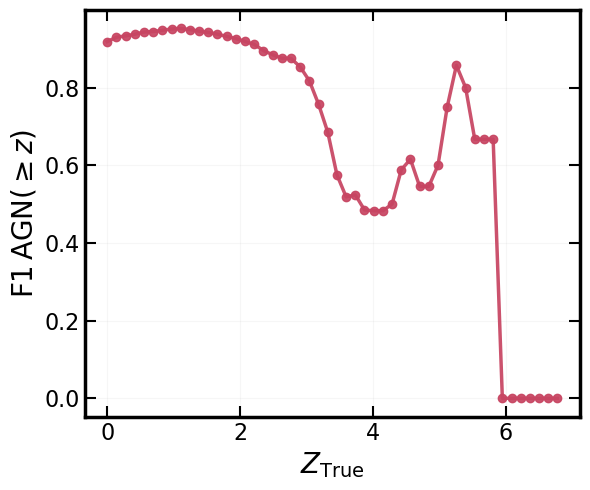

In [28]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, F1_AGN_z_lin, 'F1\,AGN', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'F1_AGN_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

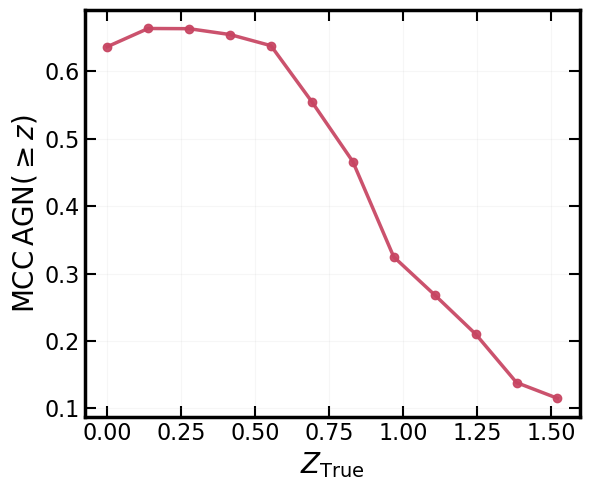

In [29]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, MCC_AGN_z_lin, 'MCC\,AGN', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'MCC_AGN_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

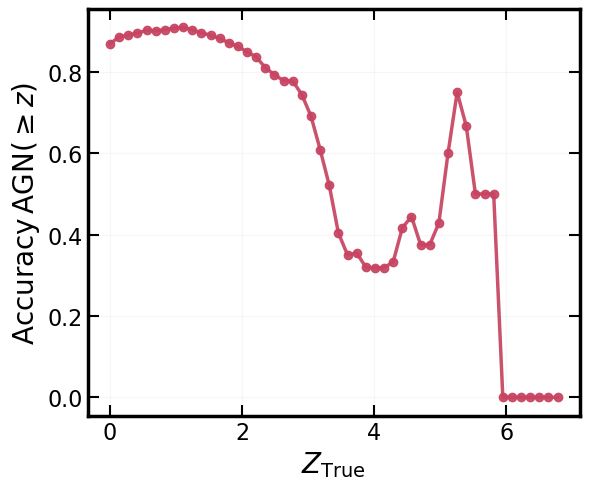

In [30]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, ACC_AGN_z_lin, 'Accuracy\,AGN', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'Accuracy_AGN_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

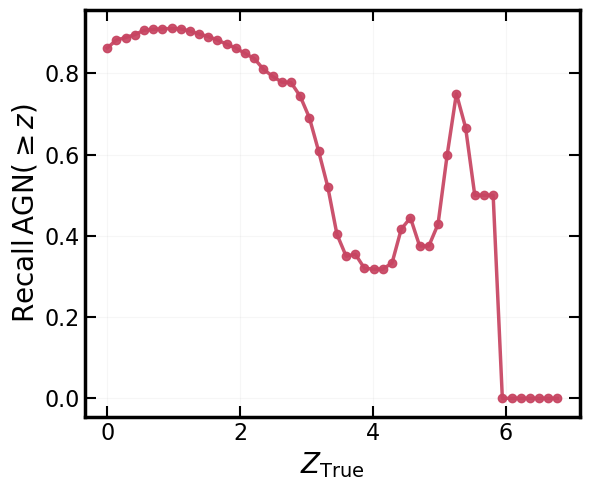

In [31]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, Rec_AGN_z_lin, 'Recall\,AGN', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'Recall_AGN_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

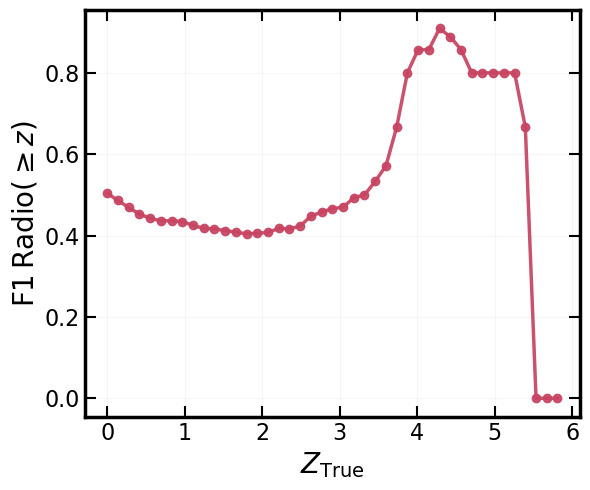

In [32]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, F1_radio_z_lin, 'F1\,Radio', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'F1_radio_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

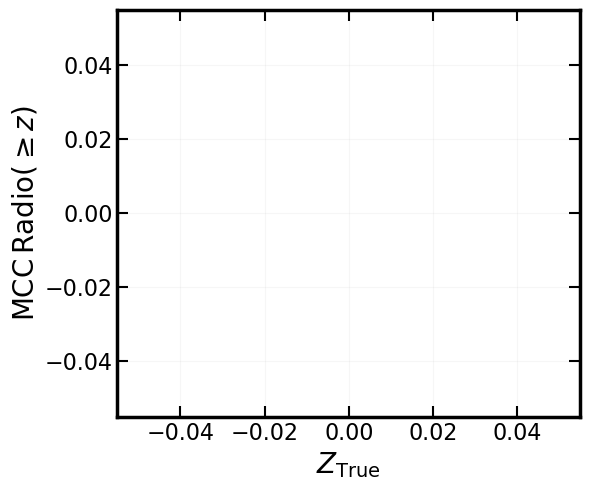

In [33]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, MCC_radio_z_lin, 'MCC\,Radio', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'MCC_radio_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

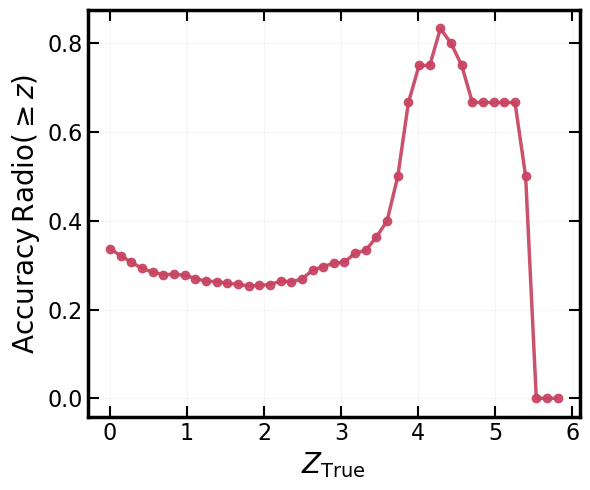

In [34]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, ACC_radio_z_lin, 'Accuracy\,Radio', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'Accuracy_radio_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

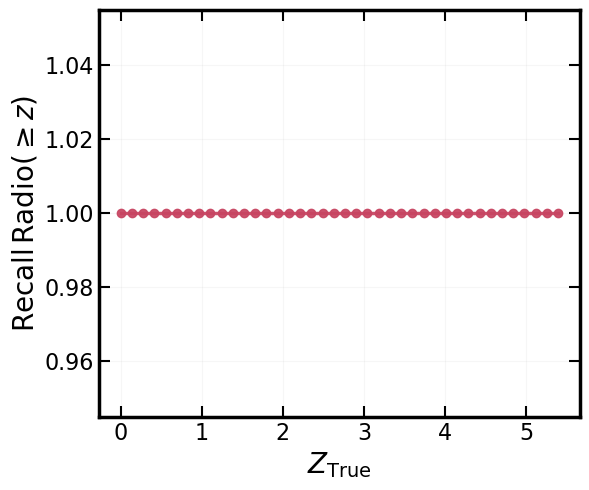

In [35]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, Rec_radio_z_lin, 'Recall\,Radio', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'Recall_radio_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

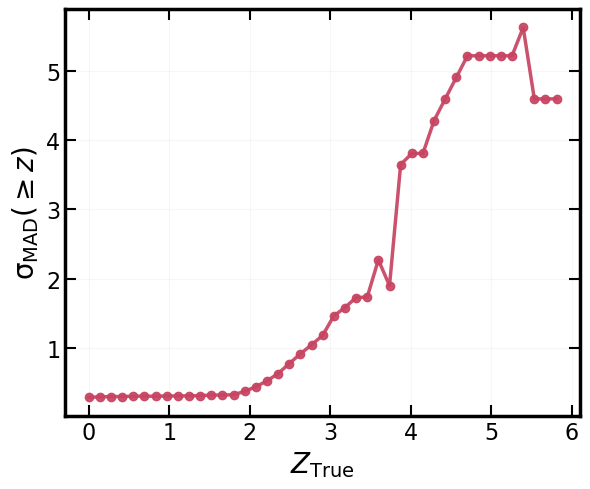

In [36]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_MAD_z_z_lin, '\sigma_{MAD}', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'sigma_MAD_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

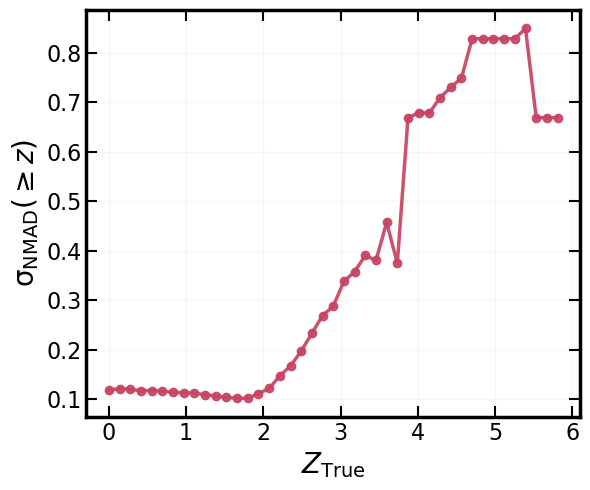

In [37]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_NMAD_z_z_lin, '\sigma_{NMAD}', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'sigma_NMAD_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

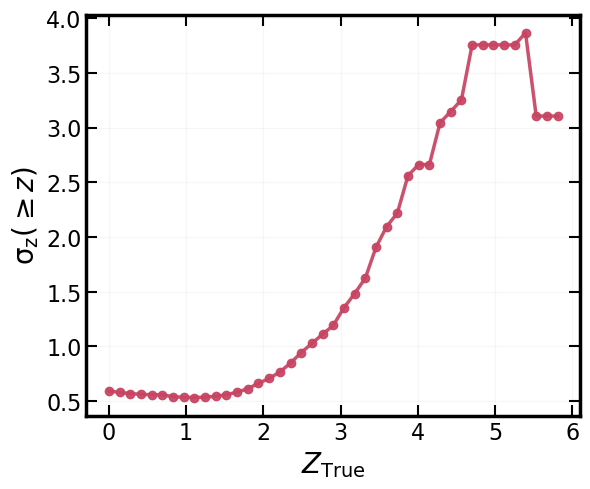

In [38]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, sigma_z_z_z_lin, '\sigma_{z}', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'sigma_z_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

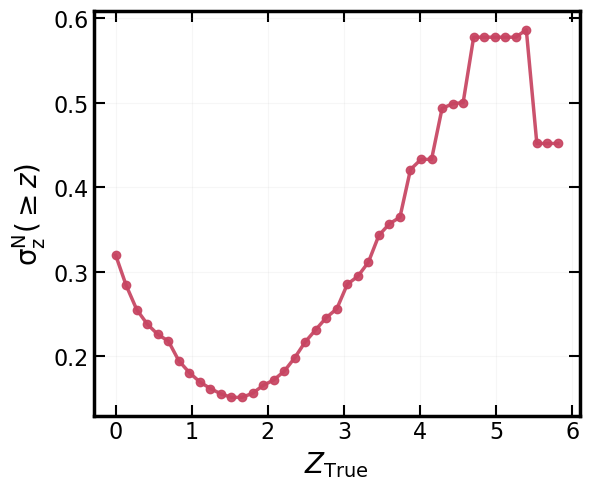

In [39]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, sigma_z_N_z_z_lin, '\sigma_{z}^{N}', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'sigma_z_N_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

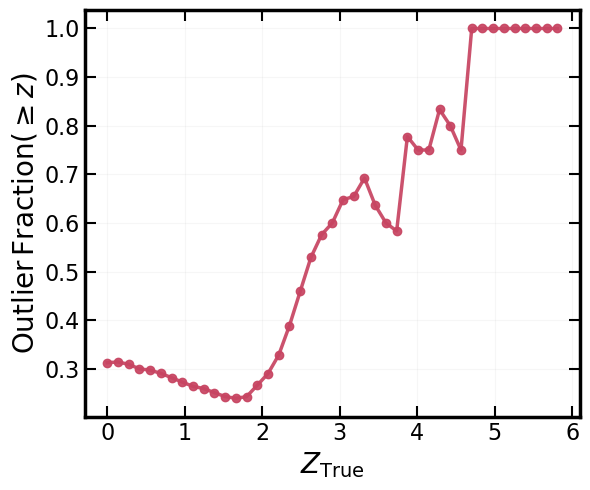

In [40]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, out_fr_z_z_lin, 'Outlier\,Fraction', ax1, title=None)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'Out_fraction_z_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

---

## Create plots for evolution of some metrics (Recall) with selected threshold

In [41]:
thresh_range_AGN       = np.linspace(catalog_for_AGN.loc[:, 'Score_AGN'].min(),     catalog_for_AGN.loc[:, 'Score_AGN'].max(), num=100)
thresh_range_radio     = np.linspace(catalog_for_radio.loc[:, 'Score_radio'].min(), catalog_for_radio.loc[:, 'Score_radio'].max(), num=100)

In [42]:
recall_vs_thresh_AGN   = metric_over_threshold(catalog_for_AGN,   'class',\
                                               'Score_AGN',    thresh_range_AGN, gf.Recall_from_CM)
MCC_vs_thresh_AGN      = metric_over_threshold(catalog_for_AGN,   'class',\
                                               'Score_AGN',    thresh_range_AGN, gf.MCC_from_CM)

recall_vs_thresh_radio = metric_over_threshold(catalog_for_radio, 'radio_detect',\
                                               'Score_radio', thresh_range_radio, gf.Recall_from_CM)
F1_vs_thresh_radio     = metric_over_threshold(catalog_for_AGN,   'radio_detect',\
                                               'Score_radio',    thresh_range_AGN, gf.F1_from_CM)

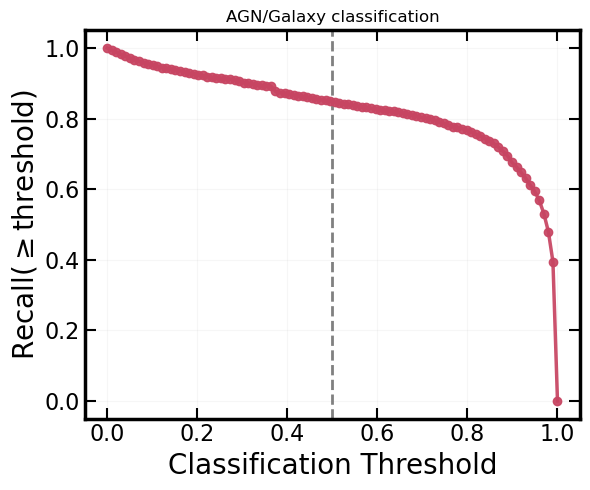

In [43]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_threshold(thresh_range_AGN, recall_vs_thresh_AGN, 'Recall', ax1, title='AGN/Galaxy classification')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'Recall_AGN_threshold_{used_area}.pdf', bbox_inches='tight')
plt.show()

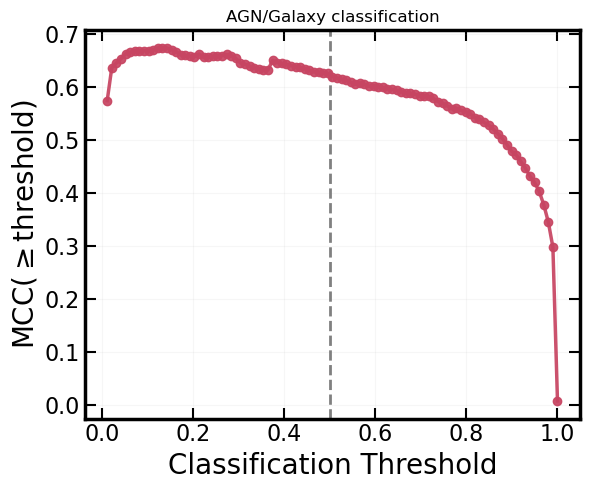

In [44]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_threshold(thresh_range_AGN, MCC_vs_thresh_AGN, 'MCC', ax1, title='AGN/Galaxy classification')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'MCC_AGN_threshold_{used_area}.pdf', bbox_inches='tight')
plt.show()

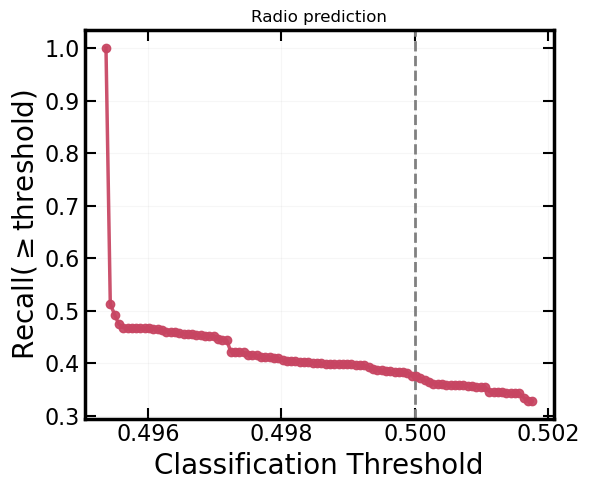

In [45]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_threshold(thresh_range_radio, recall_vs_thresh_radio, 'Recall', ax1, title='Radio prediction')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'Recall_radio_threshold_{used_area}.pdf', bbox_inches='tight')
plt.show()

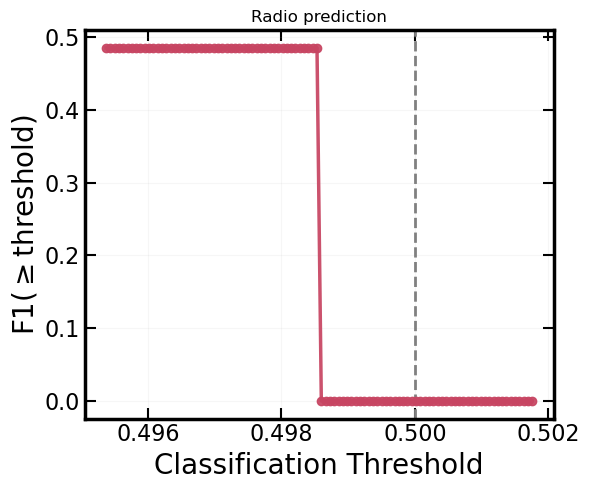

In [46]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_threshold(thresh_range_radio, F1_vs_thresh_radio, 'F1', ax1, title='Radio prediction')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'F1_radio_threshold_{used_area}.pdf', bbox_inches='tight')
plt.show()